### Load packages

In [87]:
import scanpy as sc
import episcanpy.api as epi
import numpy as np
import anndata as ad
import pandas as pd
import copy
import random

In [89]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

# Pre-processing 10x

### Load the 10x windows count matrix

In [4]:
input_dir_10x = ''
adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 545114 

### Filter barcodes

In [5]:
# Download and load the barcode file from 10x 
#!wget https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar.gz
#!gunzip -d atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar
#!tar -xvf atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.tar

In [6]:
with open('./filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]
    
annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot
del barcodes

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 545114 
    obs: 'filter_barcode_cellranger'

In [7]:
# binarize the matrix
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

298.0
1.0


### Preliminary filtering

In [8]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3879 × 545114 
    obs: 'filter_barcode_cellranger', 'nb_features'

In [9]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3879 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [10]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3879 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


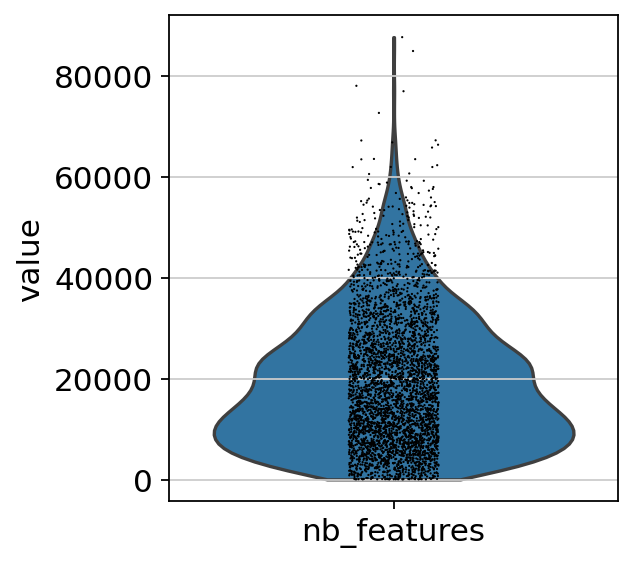

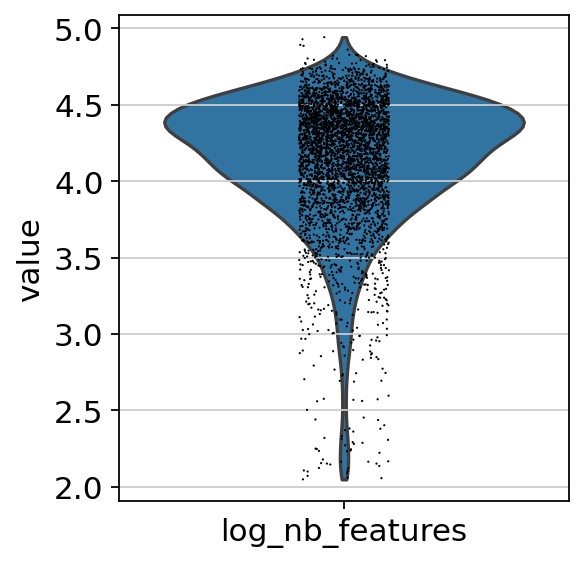

In [11]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

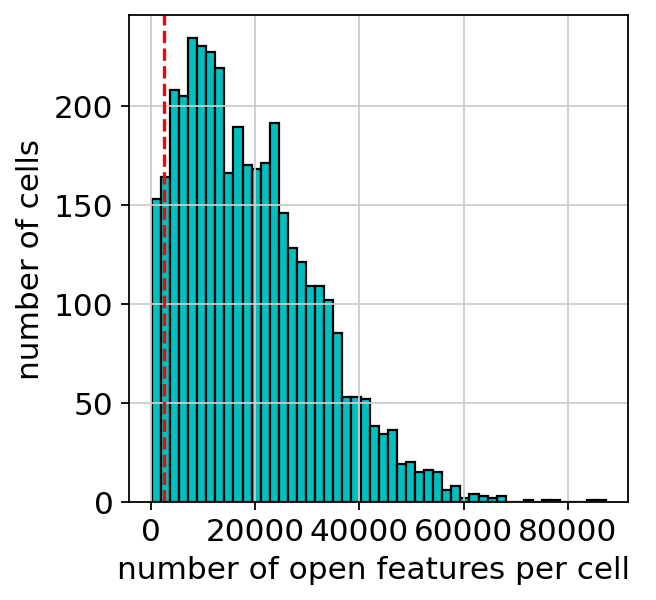

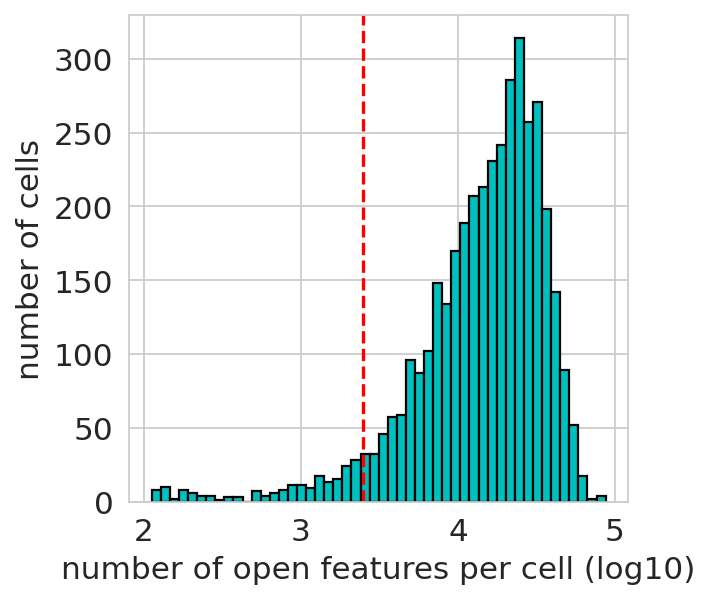

In [12]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_windows_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_windows_coverage_cells_log10.png')

In [13]:
# filter the cells not passing QC
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3667 × 459980 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

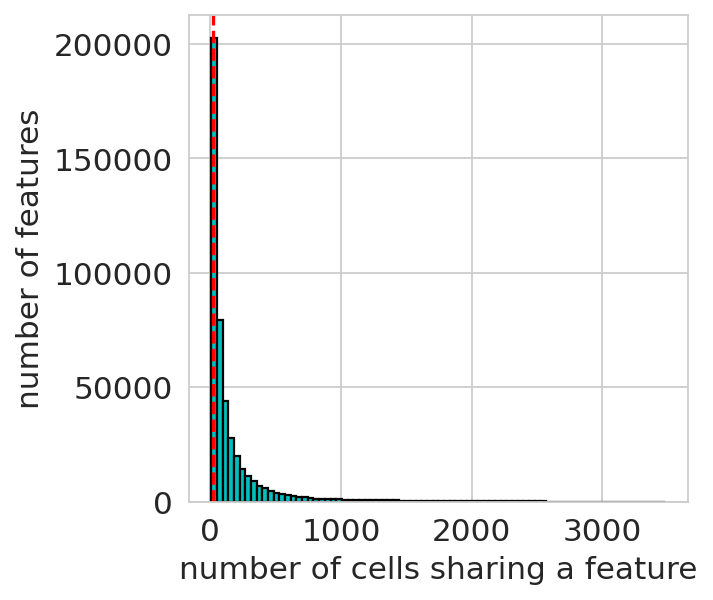

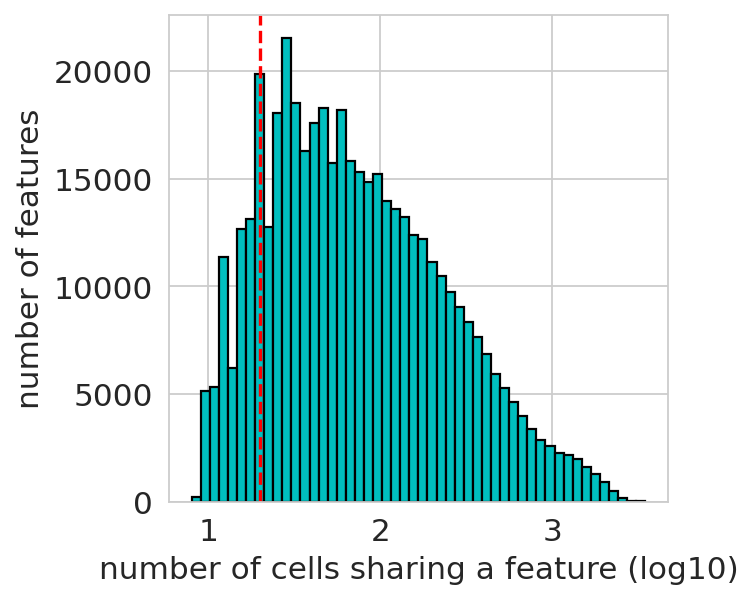

In [14]:
# minimum number of cells sharing a feature
min_cells = 20
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_windows_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_windows_coverage_log10.png')

In [15]:
# filter the features not passing QC
min_cells = 20
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3667 × 399401 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### QC post filtering

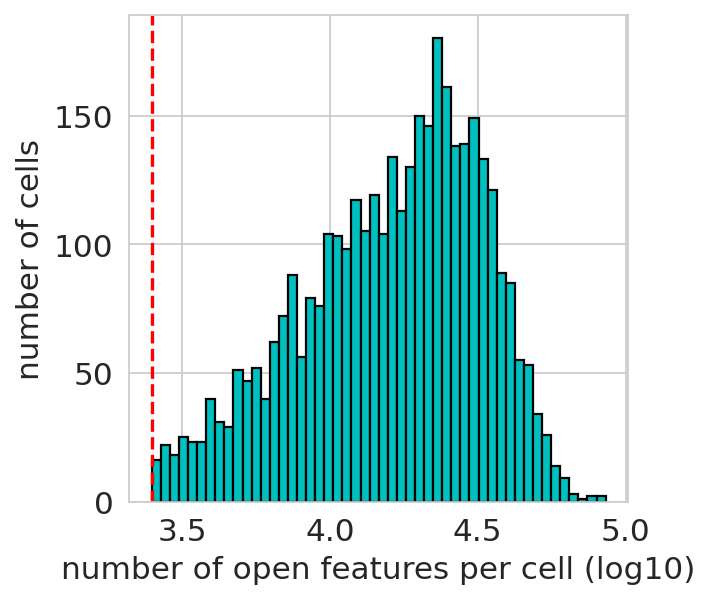

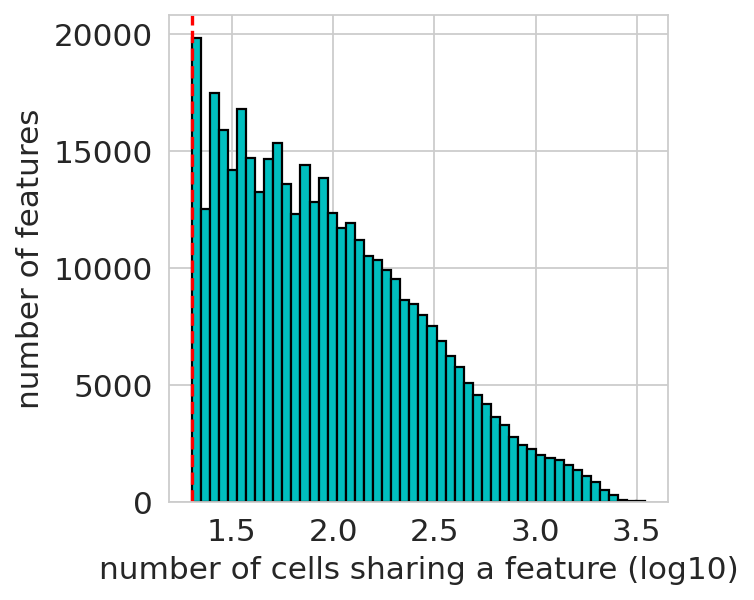

In [16]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

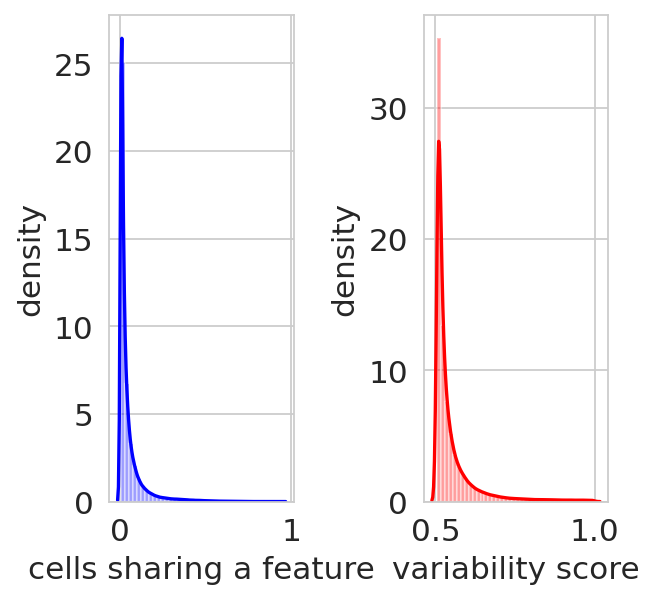

In [17]:
epi.pp.cal_var(adata)

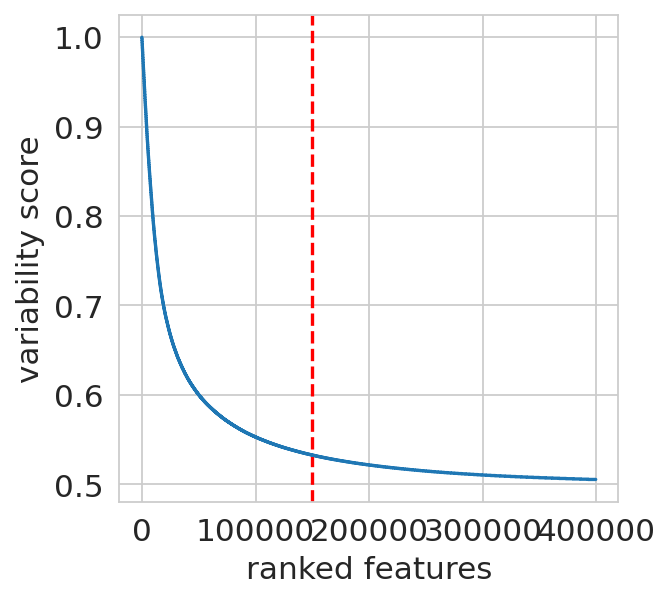

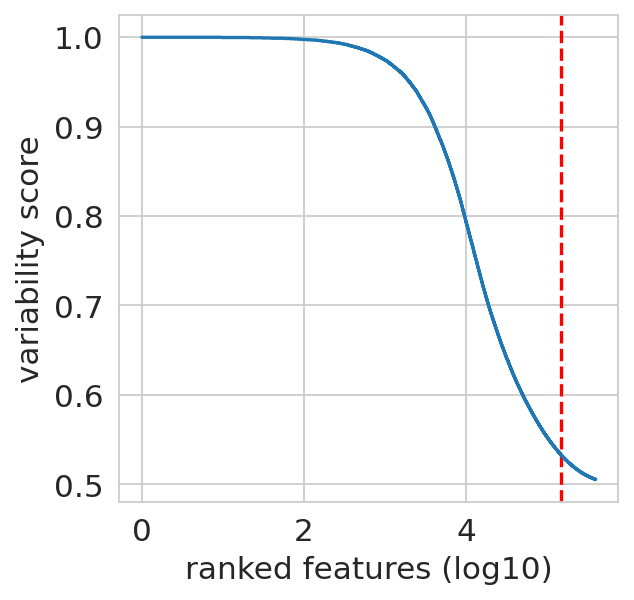

In [18]:
nb_feature_selected = 150000
epi.pl.variability_features(adata,log=None, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_windows.png')

epi.pl.variability_features(adata,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_windows_log10.png')

In [19]:
# save the current matrix in the raw layer
adata.raw = adata

In [20]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [21]:
adata

View of AnnData object with n_obs × n_vars = 3667 × 150351 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Embedding and visualisation

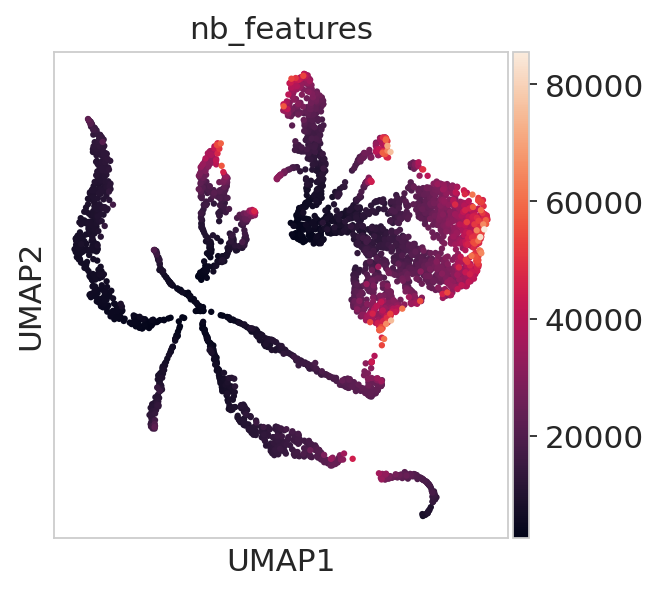

In [22]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features'], wspace=0.3)

In [23]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata.layers['counts'] = adata.X.copy()

## Pre-processing small Fang

Load CEMBA180305_2B sample from Fang et al.

In [24]:
input_dir_Fang = ''

adata2 = ad.read(input_dir_Fang+'CEMBA180305_2B_AllCells.h5ad')
adata2

AnnData object with n_obs × n_vars = 88281 × 545118 

In [25]:
# binarize the matrix
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

4886.0
1.0


### Preliminary filtering

In [26]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

AnnData object with n_obs × n_vars = 14625 × 545118 
    obs: 'nb_features'

In [27]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

AnnData object with n_obs × n_vars = 14625 × 452276 
    obs: 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [28]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

AnnData object with n_obs × n_vars = 14625 × 452276 
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells'

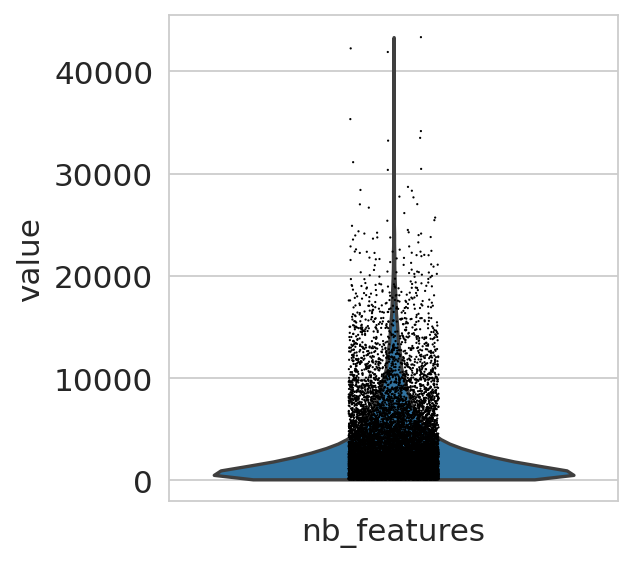

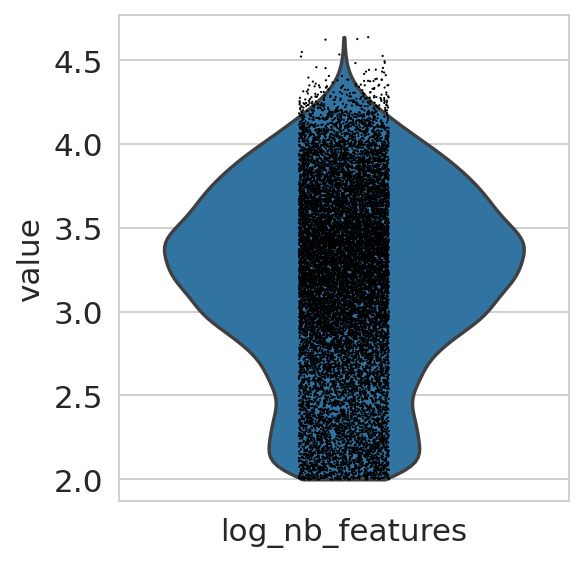

In [29]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

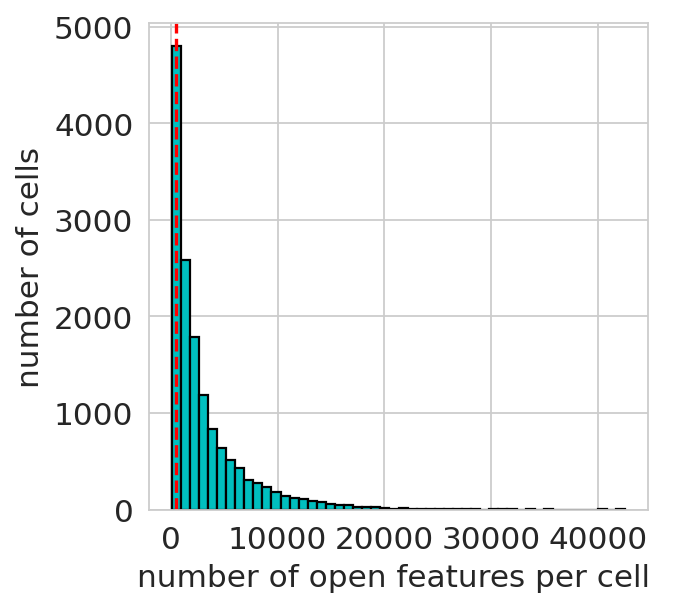

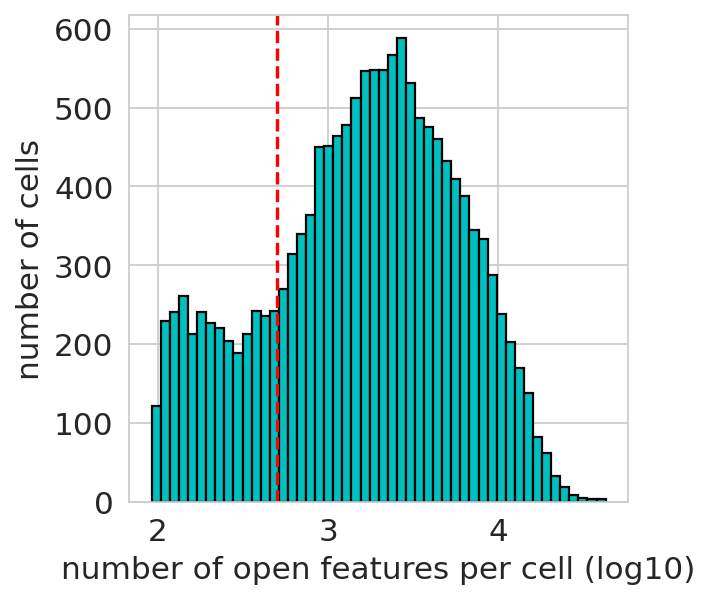

In [30]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='Fang_small_windows_coverage_cells.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='Fang_small_windows_coverage_cells_log10.png')

In [31]:
# filter the cells not passing QC
min_features = 500
epi.pp.filter_cells(adata2, min_features=min_features)
adata2

AnnData object with n_obs × n_vars = 11600 × 452276 
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells'

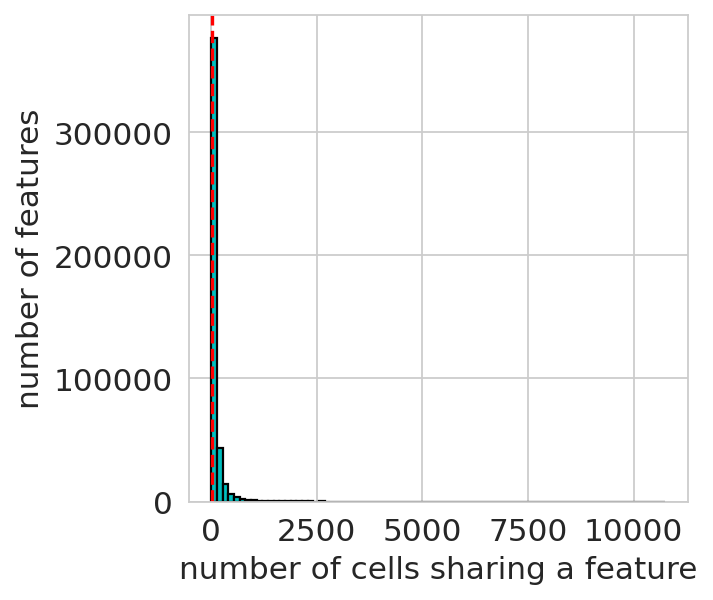

In [32]:
# minimum number of cells sharing a feature
min_cells = 20
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='Fang_small_windows_coverage.png')
#epi.pp.coverage_features(adata2, binary=True, log=True, 
#                        threshold=min_cells, save='Fang_small_windows_coverage_log10.png')

In [33]:
# filter the features not passing QC
min_cells = 20
epi.pp.filter_features(adata2, min_cells=min_cells)
adata2

AnnData object with n_obs × n_vars = 11600 × 365471 
    obs: 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### Subsampling

In [34]:
k = 4000
filtered_barcodes = random.sample(adata2.obs_names.tolist(), k)
annot = []
for n in adata2.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata2.obs['filter'] = annot
adata2 = adata2[adata2.obs['filter']=='keep',:].copy()
adata2

AnnData object with n_obs × n_vars = 4000 × 365471 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness'

### QC post filtering

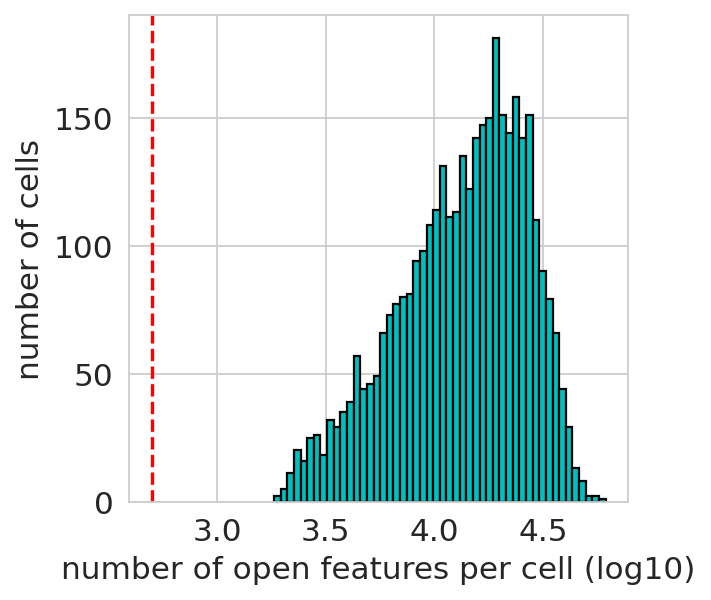

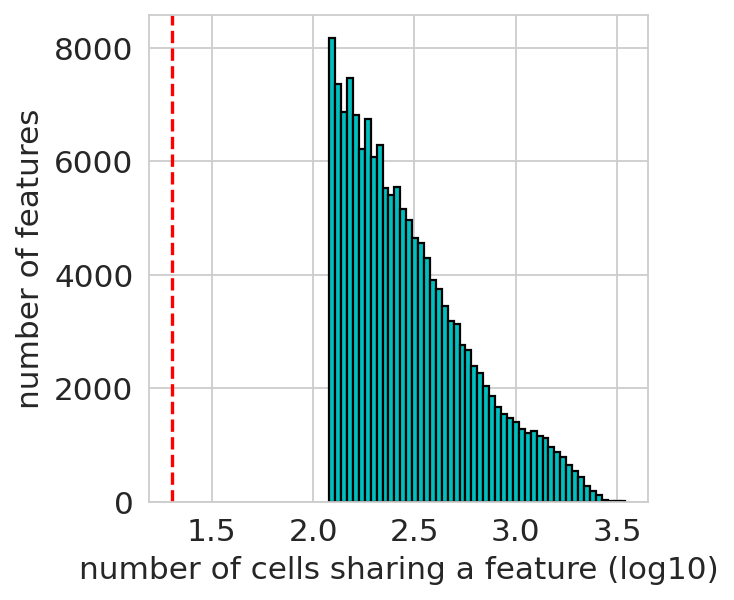

In [35]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

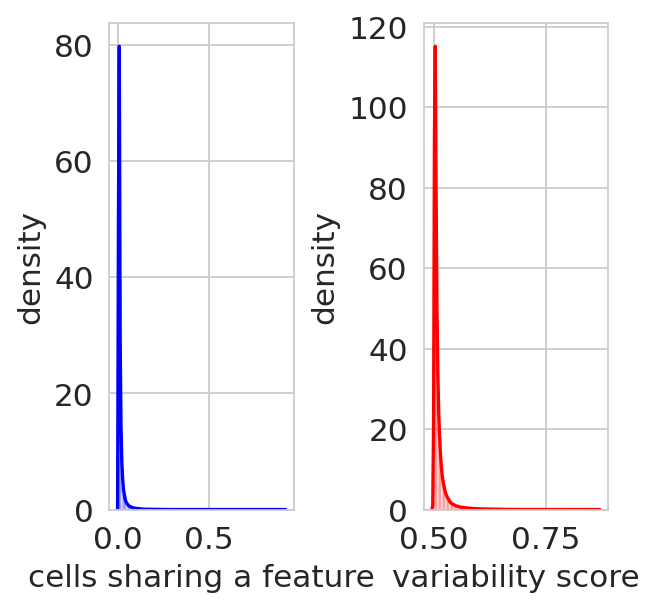

In [36]:
epi.pp.cal_var(adata2)

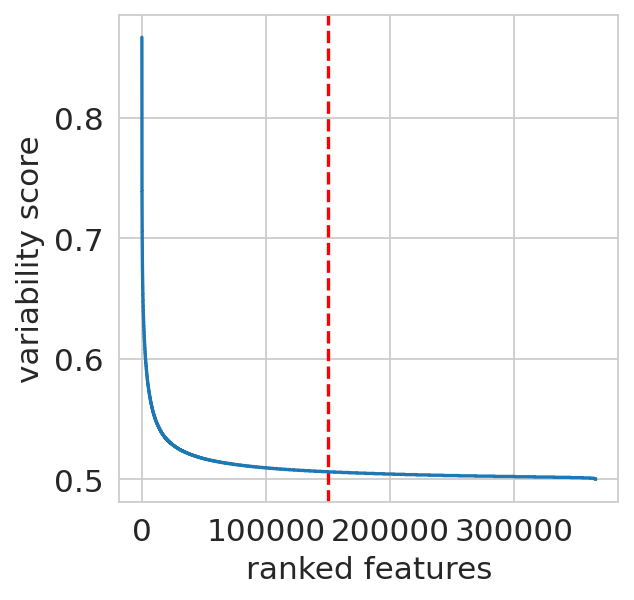

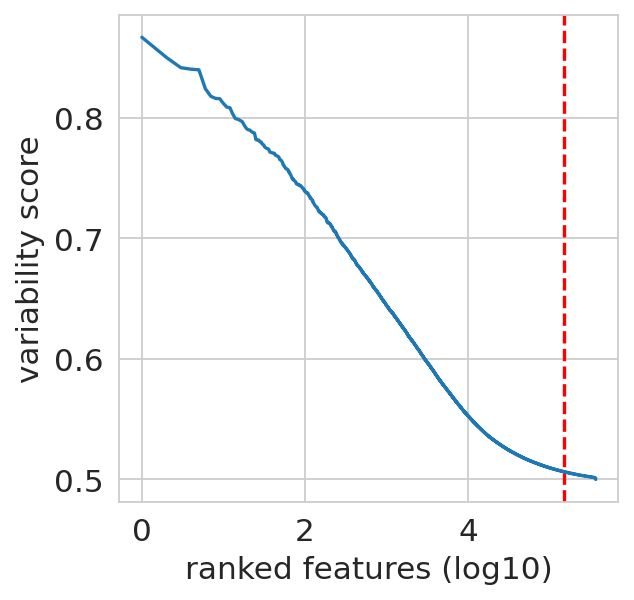

In [37]:
nb_feature_selected = 150000
epi.pl.variability_features(adata2,log=None, nb_features=nb_feature_selected,
                     save='variability_features_plot_small_windows.png')

epi.pl.variability_features(adata2,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_small_windows_log10.png')

In [38]:
adata2

AnnData object with n_obs × n_vars = 4000 × 365471 
    obs: 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [39]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [40]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [45]:
adata2.obs['batchname_Fang'] = ['CEMBA180305_2B' for n in adata2.obs_names.tolist()]
adata2

AnnData object with n_obs × n_vars = 4000 × 155001 
    obs: 'nb_features', 'log_nb_features', 'filter', 'batchname_Fang'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Embedding and visualisation

... storing 'batchname_Fang' as categorical


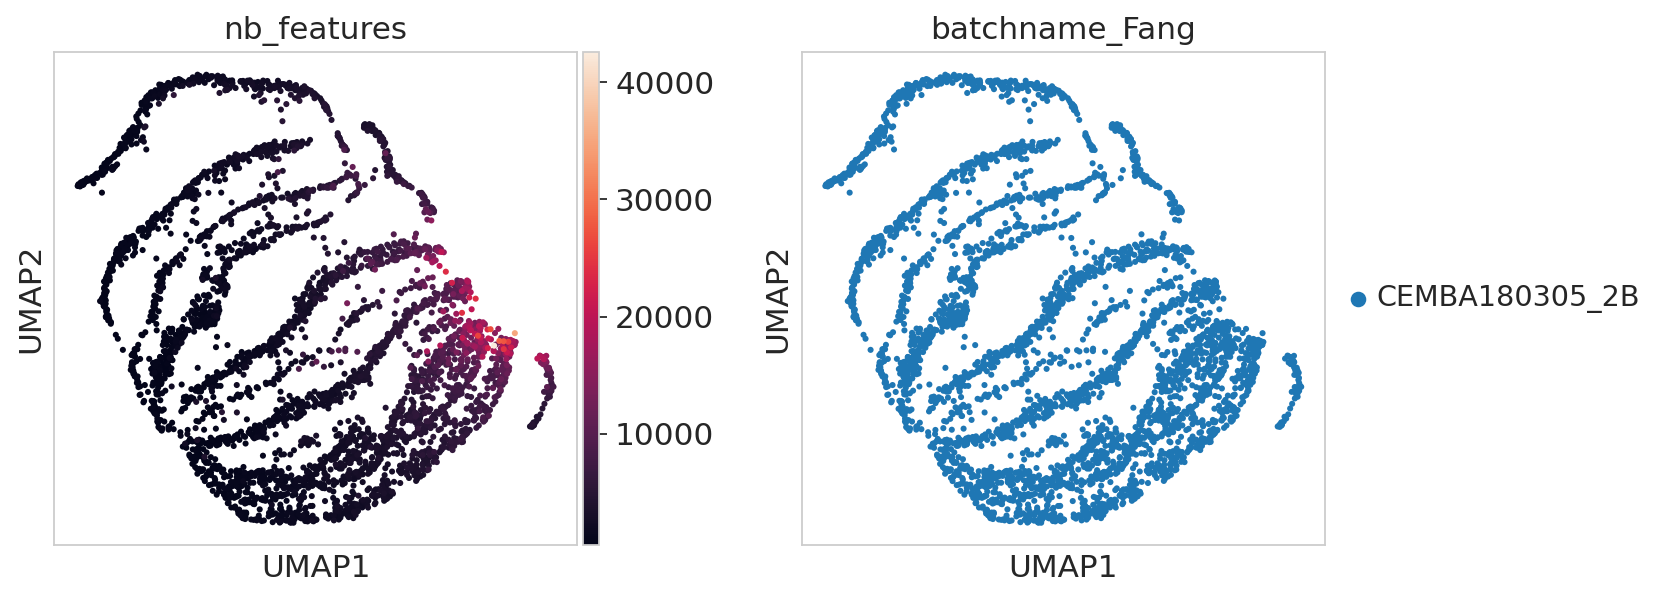

In [46]:
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features', 'batchname_Fang'], wspace=0.3)

In [47]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata2.layers['counts'] = adata2.X.copy()

## Pre-processing Cusanovich small
Load and merge all the Cusanovich samples

In [48]:
input_dir_Cusanovich = ''

In [49]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X


del adata3.obs['filter'], adatacus1, adatacus2

adata3

AnnData object with n_obs × n_vars = 35035 × 545118 

In [50]:
adata3.obs['batchname_Cusanovich'] = ['WholeBrainA_62216' for n in adata3.obs_names.tolist()]

In [51]:
# check if the data matrix is binary 
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

3454.0
1.0


### Preliminary filtering

In [52]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
adata3

AnnData object with n_obs × n_vars = 35035 × 545118 
    obs: 'batchname_Cusanovich', 'nb_features'

In [53]:
epi.pp.filter_features(adata3, min_cells=1)
adata3

AnnData object with n_obs × n_vars = 35035 × 508812 
    obs: 'batchname_Cusanovich', 'nb_features'
    var: 'n_cells'

### Quality controls & filtering

In [54]:
adata3.obs['log_nb_features'] = [np.log10(x) for x in adata3.obs['nb_features']]
adata3

AnnData object with n_obs × n_vars = 35035 × 508812 
    obs: 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells'

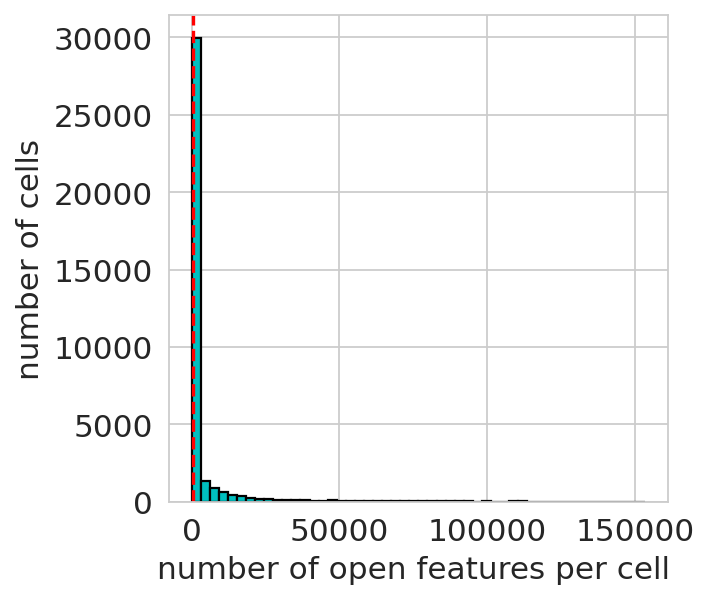

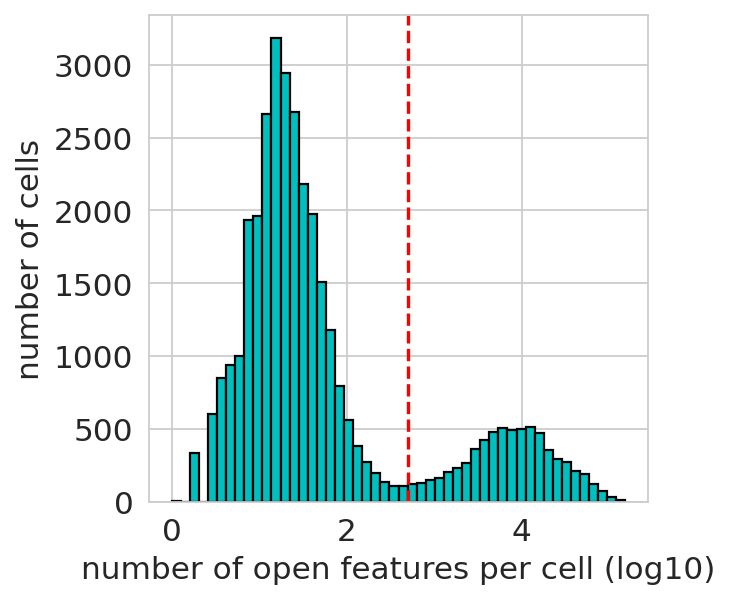

In [55]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_windows_small.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_windows_small_log10.png')

In [56]:
min_features = 500
epi.pp.filter_cells(adata3, min_features=min_features)

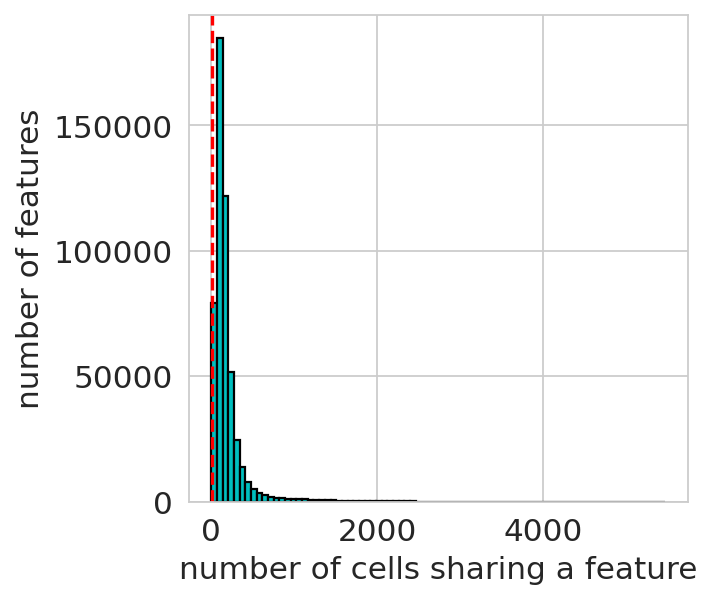

In [57]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells, save='Cusanovich_small_windows_coverage.png')
#epi.pp.coverage_features(adata3, binary=True, log=True, 
#                        threshold=min_cells, save='Cusanovich_small_windows_coverage_log10.png')

In [58]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

In [59]:
adata3

AnnData object with n_obs × n_vars = 6553 × 496033 
    obs: 'batchname_Cusanovich', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### Subsampling

In [60]:
k = 4000
filtered_barcodes = random.sample(adata3.obs_names.tolist(), k)
annot = []
for n in adata3.obs_names.tolist():
    if n in filtered_barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata3.obs['filter'] = annot
adata3 = adata3[adata3.obs['filter']=='keep',:].copy()
adata3

AnnData object with n_obs × n_vars = 4000 × 496033 
    obs: 'batchname_Cusanovich', 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness'

### QC post filtering

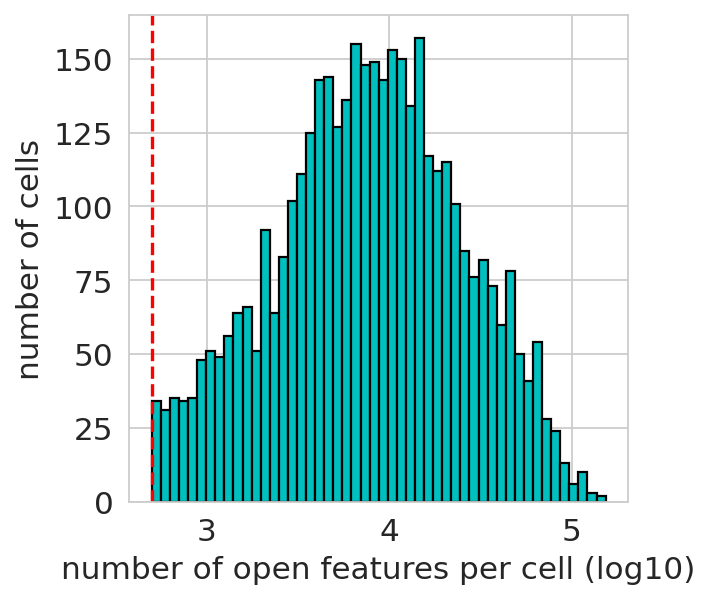

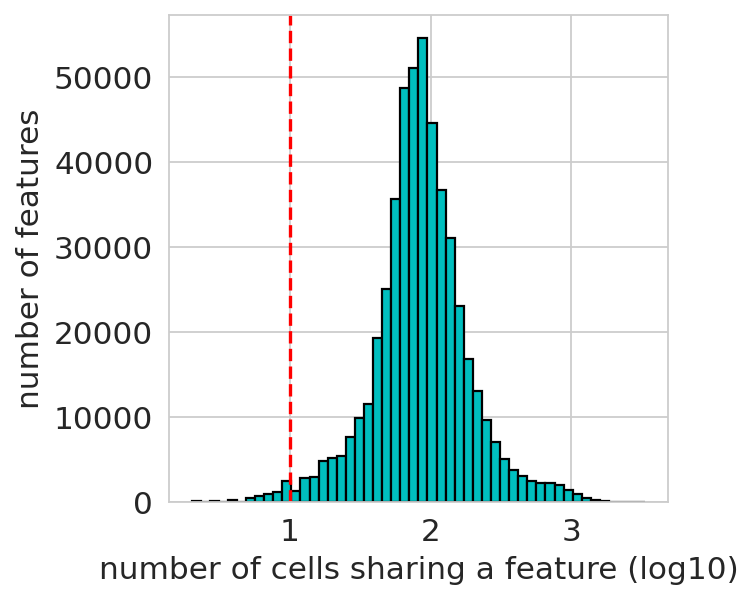

In [61]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)

### Feature selection

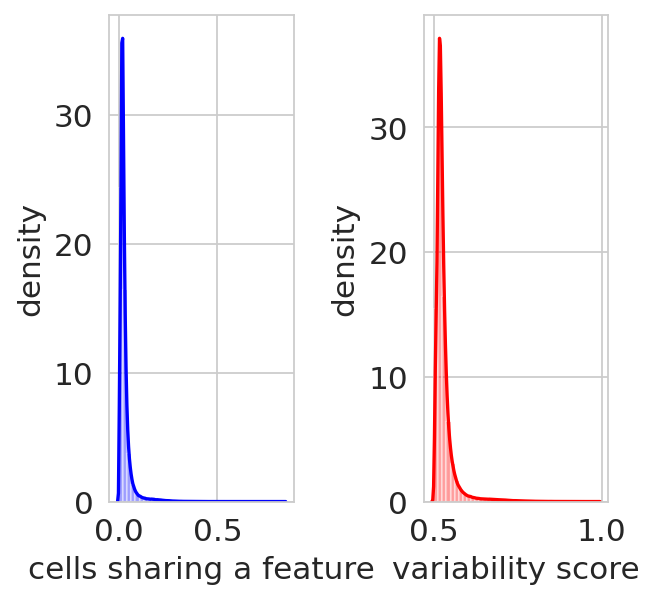

In [62]:
epi.pp.cal_var(adata3)

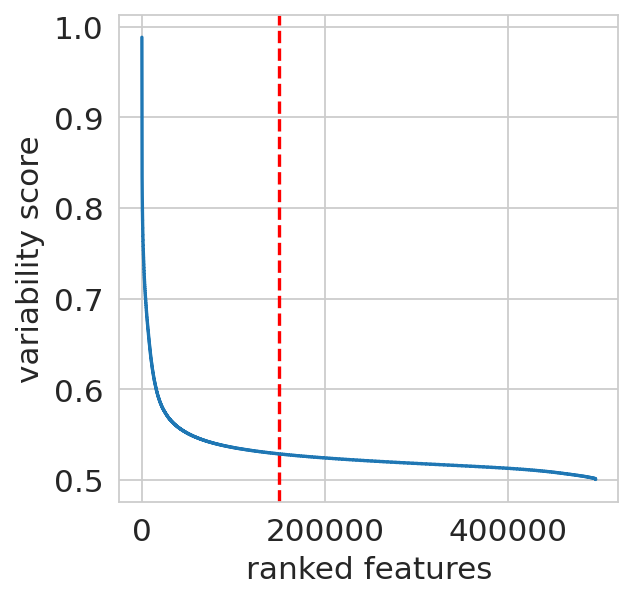

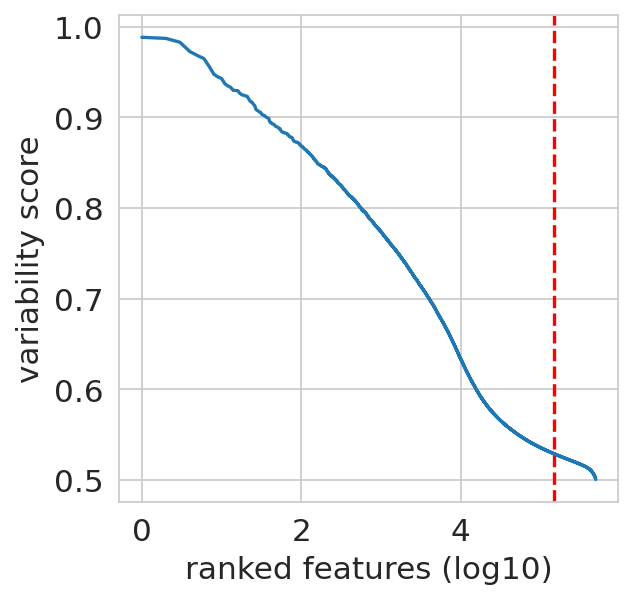

In [63]:
nb_feature_selected = 150000
epi.pl.variability_features(adata3,log=None, nb_features=nb_feature_selected,
                           save='variability_features_plot_Cusanovich_small_windows.png')

epi.pl.variability_features(adata3,log='log10', nb_features=nb_feature_selected,
                     save='variability_features_plot_Cusanovich_smal_windows_log10.png')

In [64]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [65]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [66]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

In [67]:
adata3

AnnData object with n_obs × n_vars = 4000 × 150679 
    obs: 'batchname_Cusanovich', 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'counts'

### Embedding and visualisation

... storing 'batchname_Cusanovich' as categorical
... storing 'filter' as categorical


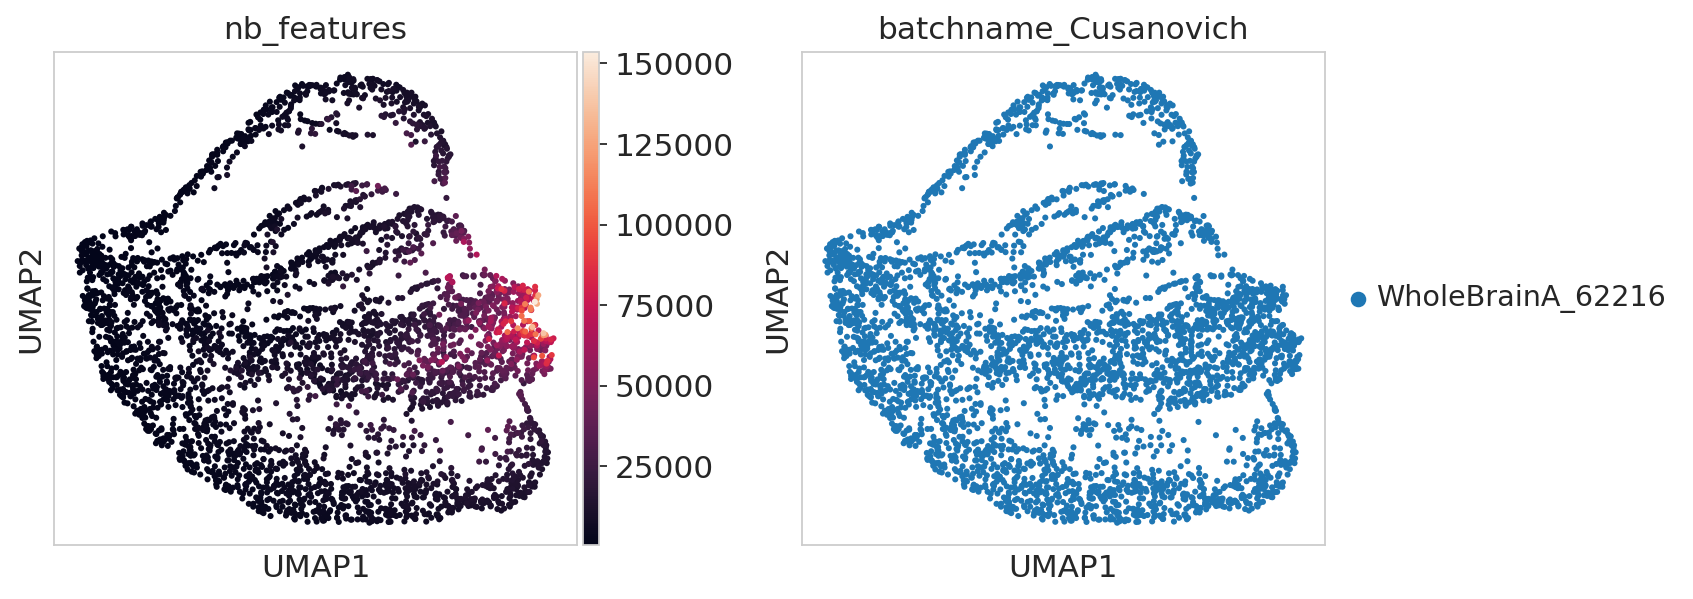

In [68]:
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features', 'batchname_Cusanovich'], wspace=0.3)

In [69]:
adata3

AnnData object with n_obs × n_vars = 4000 × 150679 
    obs: 'batchname_Cusanovich', 'nb_features', 'log_nb_features', 'filter'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'umap', 'batchname_Cusanovich_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Merging datasets

In [70]:
# merging 10x and Fang
adatamerged = adata.concatenate(adata2)
adatamerged

AnnData object with n_obs × n_vars = 7667 × 127952 
    obs: 'batch', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [71]:
batchname=copy.copy(adatamerged.obs['batch'])
batchname = batchname.map({ '1' : 'Fang et al.', '0' : '10x Genomics' })
adatamerged.obs['batchname'] = batchname
adatamerged

AnnData object with n_obs × n_vars = 7667 × 127952 
    obs: 'batch', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

### Temporary embedding

In [72]:
epi.pp.lazy(adatamerged)

... storing 'batchname_Fang' as categorical
... storing 'filter' as categorical
... storing 'filter_barcode_cellranger' as categorical


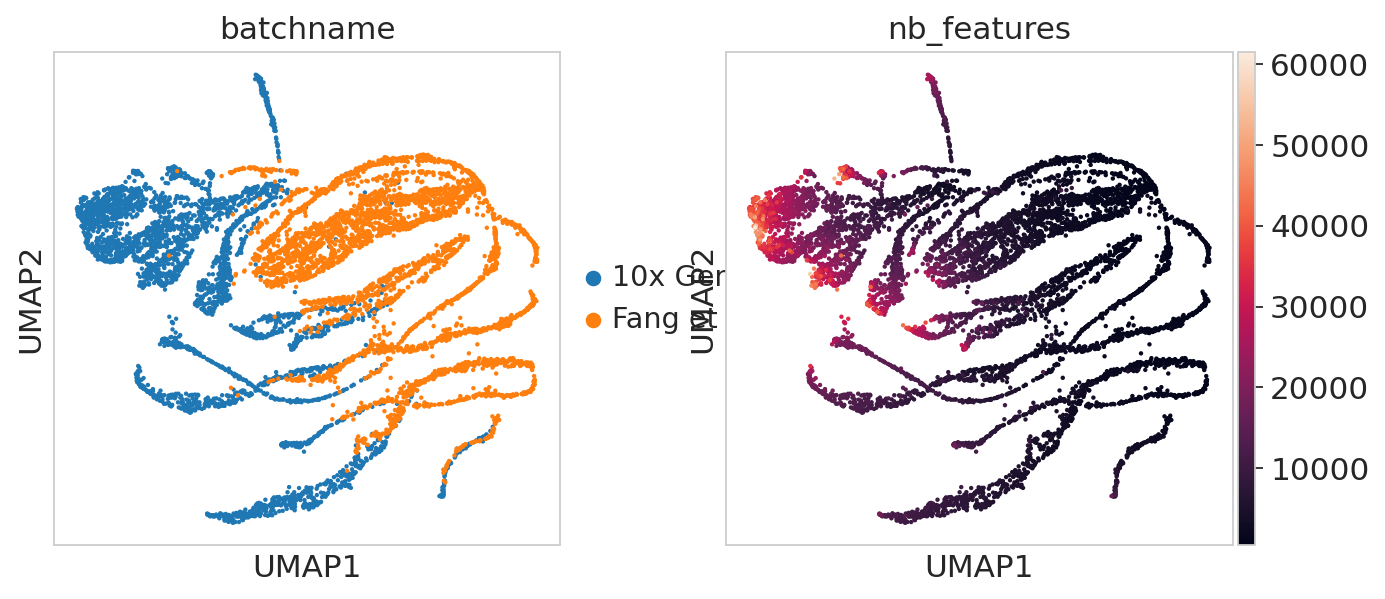

In [73]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'])

In [74]:
# adding Cusanovich data
adatamerged = adatamerged.concatenate(adata3)
adatamerged

AnnData object with n_obs × n_vars = 11667 × 110724 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [75]:
adatamerged.obs['batchname'] = adatamerged.obs['batchname'].replace(np.nan, 'Cusanovich et al.', regex=False)

annot = []
index = 0
for n in adatamerged.obs_names.tolist():
    if adatamerged.obs['batchname'][index] == '10x Genomics':
        annot.append('10x Genomics')
    elif adatamerged.obs['batchname'][index] == 'Cusanovich et al.':
        annot.append(' - '.join(['Fang et al.', adatamerged.obs['batchname_Cusanovich'][index]]))
    elif adatamerged.obs['batchname'][index] == 'Fang et al.':
        annot.append(' - '.join(['Fang et al.', adatamerged.obs['batchname_Fang'][index]]))
    else:
        annot.append(n)
    index += 1
    
adatamerged.obs['batchname_all'] = annot

In [76]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname'],
                                adatamerged.obs['batchname'],
                                margins = True)
print(contingency_table_prefilt)

batchname          10x Genomics  Cusanovich et al.  Fang et al.    All
batchname                                                             
10x Genomics               3667                  0            0   3667
Cusanovich et al.             0               4000            0   4000
Fang et al.                   0                  0         4000   4000
All                        3667               4000         4000  11667


In [77]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname_all'],
                                adatamerged.obs['batchname_all'],
                                margins = True)
print(contingency_table_prefilt)

batchname_all                    10x Genomics  Fang et al. - CEMBA180305_2B  \
batchname_all                                                                 
10x Genomics                             3667                             0   
Fang et al. - CEMBA180305_2B                0                          4000   
Fang et al. - WholeBrainA_62216             0                             0   
All                                      3667                          4000   

batchname_all                    Fang et al. - WholeBrainA_62216    All  
batchname_all                                                            
10x Genomics                                                   0   3667  
Fang et al. - CEMBA180305_2B                                   0   4000  
Fang et al. - WholeBrainA_62216                             4000   4000  
All                                                         4000  11667  


### Filtering cells that do not contain sufficient data

In [78]:
epi.pp.filter_cells(adatamerged, min_features=500)

In [79]:
contingency_table_prefilt = pd.crosstab(adatamerged.obs['batchname'],
                                adatamerged.obs['batchname'],
                                margins = True)
print(contingency_table_prefilt)

batchname          10x Genomics  Cusanovich et al.  Fang et al.    All
batchname                                                             
10x Genomics               3667                  0            0   3667
Cusanovich et al.             0               3787            0   3787
Fang et al.                   0                  0         3680   3680
All                        3667               3787         3680  11134


In [80]:
adatamerged.layers['counts'] = adatamerged.X

### Embedding and Visualisation

In [81]:
epi.pp.lazy(adatamerged)

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical
... storing 'batchname_Fang' as categorical
... storing 'filter' as categorical
... storing 'filter_barcode_cellranger' as categorical
... storing 'batchname_all' as categorical


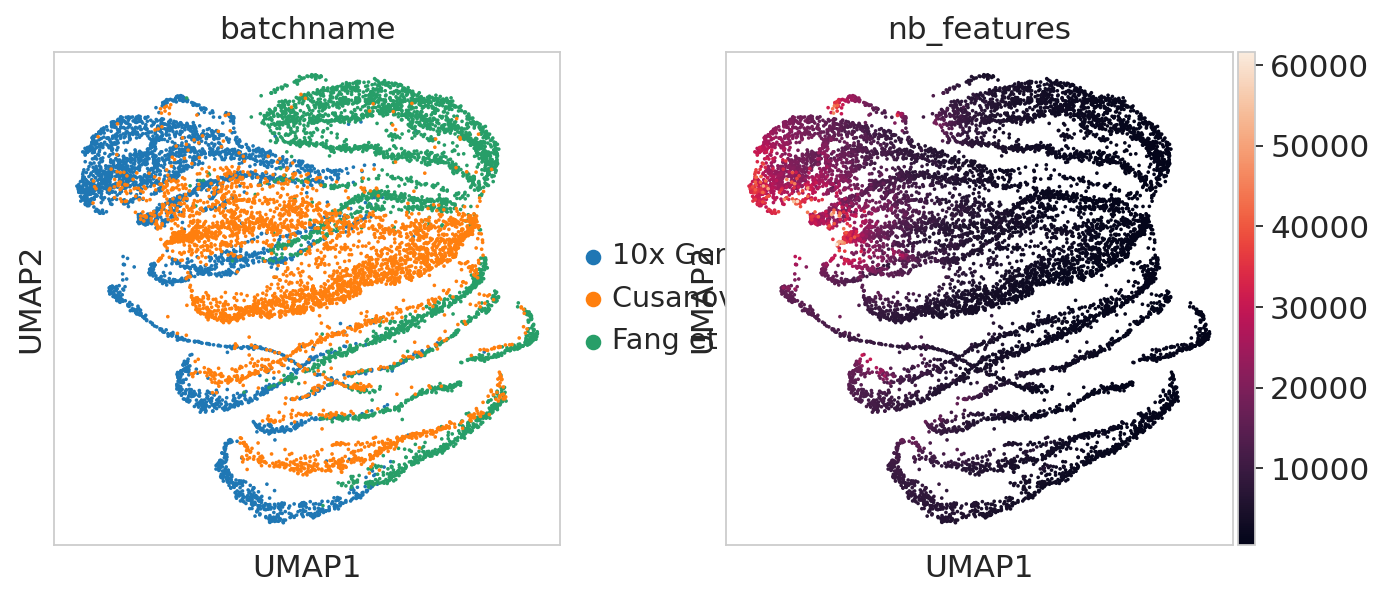

In [82]:
epi.pl.umap(adatamerged, color=['batchname', 'nb_features'])

### Normalisation

In [83]:
epi.pp.normalize_per_cell(adatamerged)

### Embedding and visualisation

In [84]:
epi.pp.lazy(adatamerged)

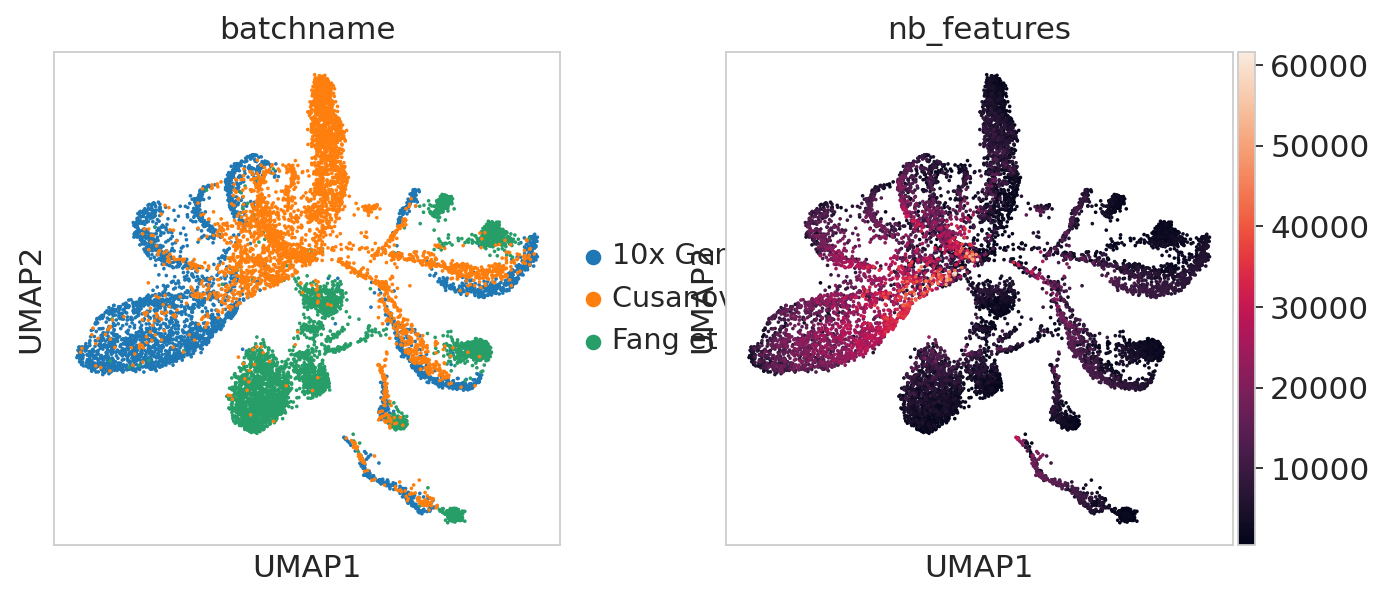

In [85]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'])

### Saving the data

In [86]:
adatamerged.write('small_dataset_merged_dataset.h5ad')